In [ ]:
!pip install transformers
!pip install evaluate
!pip install sentencepiece
!pip install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 35.8 MB/s 
     |████████████████████████████████| 120 kB 70.5 MB/s 
     |████████████████████████████████| 6.6 MB 66.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 313 kB/s 
     |████████████████████████████████| 212 kB 65.6 MB/s 
     |████████████████████████████████| 115 kB 53.3 MB/s 
     |████████████████████████████████| 431 kB 57.5 MB/s 
     |████████████████████████████████| 127 kB 75.7 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 31.2 MB/s 
Looking in indexes: http

In [ ]:
import torch
import re
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, RandomSampler
import pytorch_lightning as pl
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from nltk.stem import WordNetLemmatizer
nltk.download("wordnet")
nltk.download('omw-1.4')
import os
import string
import torch.nn as nn
import pandas as pd
import numpy as np
import evaluate
import matplotlib.pyplot as plt
import transformers
from transformers import T5ForConditionalGeneration, T5Tokenizer
from transformers import get_linear_schedule_with_warmup, AdamW
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
df = pd.read_csv("news_summary.csv")

In [ ]:
df.head()

,headlines,text
0,upGrad learner switches to career in ML & AI w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


In [ ]:
df.shape

(24690, 2)

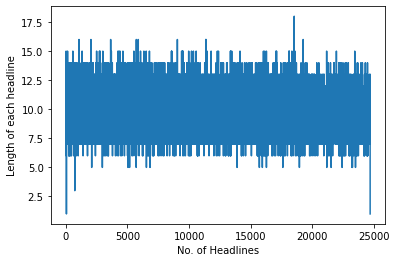

In [ ]:
df["headlines"].str.split().str.len().plot()
plt.xlabel("No. of Headlines")
plt.ylabel("Length of each headline")
plt.show()

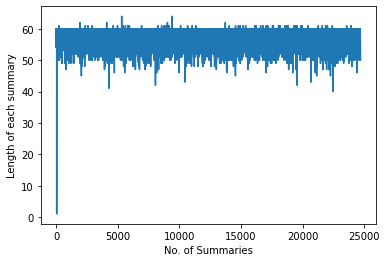

In [ ]:
df["text"].str.split().str.len().plot()
plt.xlabel("No. of Summaries")
plt.ylabel("Length of each summary")
plt.show()

In [ ]:
print("Average length of Headline: ", round(df["headlines"].str.split().str.len().mean()))
print("Average length of Text: ", round(df["text"].str.split().str.len().mean()))

Average length of Headline:  10
Average length of Text:  58


In [ ]:
MODEL = T5ForConditionalGeneration.from_pretrained("t5-base", return_dict=True)
TOKENIZER = T5Tokenizer.from_pretrained("t5-base")
BATCH_SIZE = 4
TEXT_LEN = 512
HEADLINE_LEN = 64
EPOCHS = 2
DEVICE = "cuda:0"

Downloading:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/892M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

In [ ]:
class NewsSummaryDataset(Dataset):
    def __init__(self, df, tokenizer, text_len, headline_len):
        self.df = df
        self.headlines = self.df["headlines"]
        self.text = self.df["text"]
        self.tokenizer = tokenizer
        self.text_len = text_len
        self.headline_len = headline_len
  
    def __len__(self):
        return len(self.headlines)
  
    def __getitem__(self, idx):
        # T5 transformers performs different tasks by prepending the particular prefix to the input text.
        text = "summarize:" + str(self.text[idx])                # In order to avoid dtype mismatch, as T5 is text-to-text transformer, the datatype must be string
        headline = str(self.headlines[idx])

        text_tokenizer = self.tokenizer(text, max_length=self.text_len, padding="max_length",
                                                        truncation=True, add_special_tokens=True)
        headline_tokenizer = self.tokenizer(headline, max_length=self.headline_len, padding="max_length",
                                                        truncation=True, add_special_tokens=True)
        return {
            "input_ids": torch.tensor(text_tokenizer["input_ids"], dtype=torch.long),
            "attention_mask": torch.tensor(text_tokenizer["attention_mask"], dtype=torch.long),
            "summary_ids": torch.tensor(headline_tokenizer["input_ids"], dtype=torch.long),
            "summary_mask": torch.tensor(headline_tokenizer["attention_mask"], dtype=torch.long)
        }

In [ ]:
class NewsSummaryDataModule(pl.LightningDataModule):
    def __init__(self, 
                train_df, 
                val_df,
                test_df,
                batch_size,
                tokenizer,
                text_len,
                summary_len):
        super().__init__()
        self.train_df = train_df
        self.val_df = val_df
        self.batch_size = batch_size
        self.test_df = test_df
        self.tokenizer = tokenizer
        self.text_len = text_len
        self.summary_len = summary_len
    
    def setup(self, stage=None):
        self.train_dataset = NewsSummaryDataset(
            self.train_df,
            self.tokenizer,
            self.text_len,
            self.summary_len)
        
        self.val_dataset = NewsSummaryDataset(
            self.val_df,
            self.tokenizer,
            self.text_len,
            self.summary_len)
        
        self.test_dataset = NewsSummaryDataset(
            self.test_df,
            self.tokenizer,
            self.text_len,
            self.summary_len
        )
    
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=4)
    
    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            num_workers=4)
        
    def test_dataloader(self):
        return DataLoader(
              self.test_dataset,
              batch_size=self.batch_size,
              num_workers=4
          )

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

In [ ]:
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [ ]:
news_summary_module = NewsSummaryDataModule(train_df, val_df, test_df, BATCH_SIZE, TOKENIZER, TEXT_LEN, HEADLINE_LEN)
news_summary_module.setup()

In [ ]:
next(iter(news_summary_module.train_dataloader().dataset))

{'input_ids': tensor([21603,    10,   634,   868,  1958,  2402, 24910,    41,  8137,  9012,
            61,    65,  1380, 19871,  2157,  1547,    31,     7,  2519,    52,
            11,   529,    18,  6667,  3044,   757, 11636,   891,   107, 17279,
            17, 13509,   152,    12,    59,  1175,     8,   684,   406,  6059,
            13,     8,  5779,  4376,     5,    37,  3545,  1925,    13,  1547,
            65,  1026,     8,  3620,  1449,  1669,    12,     8,    16,  6065,
          4392,  1614,  1854,  3896,     3,     9,  4647,    13,   147,     3,
          1439,     2,  2368,  1808, 23095,     5,    37, 15810,    18,   390,
           349,    65,     3,     9,   792,  2814,    13,   300,     3,  1439,
             2,   536, 18834, 23095,     5,     1,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

In [ ]:
class NewsSummaryModel(pl.LightningModule):
    def __init__(self):
        super(NewsSummaryModel, self).__init__()
        self.model = MODEL
  
    def forward(self, input_ids, attention_mask, labels=None, decoder_attention_mask=None):
        outputs = self.model(input_ids=input_ids,
                        attention_mask=attention_mask,
                        labels=labels,
                        decoder_attention_mask=decoder_attention_mask)
        return outputs.loss, outputs.logits
  
    def training_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["summary_ids"]
        decoder_attention_mask = batch["summary_mask"]

        loss, output = self(input_ids, attention_mask, labels, decoder_attention_mask)
        return loss

    def validation_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["summary_ids"]
        decoder_attention_mask = batch["summary_mask"]

        loss, output = self(input_ids, attention_mask, labels, decoder_attention_mask)
        return loss
 
    def test_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        loss, output = self(input_ids=input_ids, 
                      attention_mask=attention_mask)
        return loss
    
    def configure_optimizers(self):
        optimizer = AdamW(self.model.parameters(), lr=0.0001)
        scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=0,
                num_training_steps=EPOCHS*len(df))
        return {'optimizer': optimizer, 'lr_scheduler': scheduler}

In [ ]:
model = NewsSummaryModel()

In [ ]:
trainer = pl.Trainer(
    max_epochs=EPOCHS,
    gpus=1
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, news_summary_module)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 222 M 
-----------------------------------------------------
222 M     Trainable params
0         Non-trainable params
222 M     Total params
891.614   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


In [ ]:
# Loading the best model

news_summary_model = NewsSummaryModel.load_from_checkpoint(
    trainer.checkpoint_callback.best_model_path
)
news_summary_model.freeze()

In [ ]:
def summarize(text):
    inputs = TOKENIZER(text, 
                       max_length=TEXT_LEN,
                       truncation=True,
                       padding="max_length",
                       add_special_tokens=True, 
                       return_tensors="pt")
    summarized_ids = news_summary_model.model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"], 
        num_beams=4)

    return " ".join([TOKENIZER.decode(token_ids, skip_special_tokens=True)
                    for token_ids in summarized_ids])

In [ ]:
text = df.iloc[100]["text"]
headline = df.iloc[100]["headlines"]
summarized_text = summarize(text)

In [ ]:
bleu = evaluate.load("google_bleu")

In [ ]:
bleu.compute(predictions=[summarized_text], references=[headline])

{'google_bleu': 0.2894736842105263}

In [ ]:
import pickle


filename = open('summarization_model.pkl', 'wb')
pickle.dump(news_summary_model.model, filename)